## 📊 Autograd Graph Visualization Tool
This tool helps you visualize the computation graph of scalar operations built using a custom class. It displays both the forward pass values and the backward gradients for each node in your computation.
## ⚙️ Environment Setup
### 🐧 Linux
Activate your idls25 conda environment:

```python
$conda activate idls25
$conda install -c conda-forge python-graphviz
```

Then install the Graphviz binary required for rendering:

```python
$sudo apt update
$sudo apt install graphviz
```

Now confirm Graphviz is installed by running:

```python
$which dot
```
This should return 
> miniconda3/envs/idls25/bin/dot

### 🍎 macOS
Activate your idls25 conda environment:

```python
$conda activate idls25
$conda install -c conda-forge python-graphviz
```

Also install Graphviz using Homebrew:

```python
$brew install graphviz
```

Now confirm Graphviz is installed by running:

```python
$which dot
```

Should return something like:
> /opt/homebrew/bin/dot

### 🪟 Windows
Activate your idls25 conda environment:

```python
$conda activate idls25
$conda install -c conda-forge python-graphviz
```

Download and install Graphviz from the official site:
👉 https://graphviz.org/download/

After installation, add the Graphviz bin directory (e.g., C:\Program Files\Graphviz\bin) to your System Environment Variables → PATH.

Then confirm it's installed:

```python
$where dot
```
Should return:
> C:\Program Files\Graphviz\bin\dot.exe


In [ ]:
from graphviz import Digraph
from mytorch.functional_hw1 import Value

# Basic Engine for working
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        label_prefix = f"{n.label} = " if hasattr(n, 'label') and n.label else ""
        node_label = f"{{ {label_prefix}data {n.data:.4f} | grad {n.grad:.4f} }}"
        dot.node(name=str(id(n)), label = node_label, shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## 🚀 Using the Visualization Tool
Above you can get a general idea of how the autograd graph is created. After building your computation with the Value class, you can call:

```python
$draw_dot(y)
```

Where y is the final output node of your computation.

This will render a computation graph with:

Each node showing:

data: the output value from the forward pass

grad: the gradient from the backward pass

Each edge representing a dependency in computation

## ✅ Supported Operations
The visualization currently supports the following operations:

|    Operation   | Symbol / Name |
|:--------------:|:-------------:|
| Addition       | +             |
| Subtraction    | -             |
| Multiplication | * or x        |
| Division       | /             |
| Logarithm      | log           |
| Exponential    | exp           |
| Power          | **            |
| ReLU           | relu          |
| Tanh           | tanh          |
| Sigmoid        | sigmoid       |

## 🧪 Example Usage


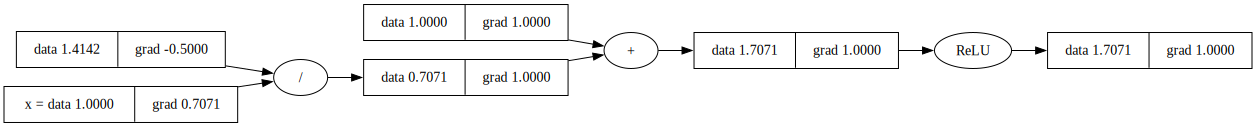

In [14]:
x = Value(1.0,label='x')
y = ((x / 2**0.5 + 1).relu())
y.backward()
draw_dot(y)
# This will produce a left-to-right graph of the operations that led from x to y = ((x / 2**0.5 + 1).relu()), and display how gradients flow backward during .backward().

# ✅ Verification of Autograd Graph Calculation

This document verifies the values and gradients shown in the autograd graph visualization generated for the following code:

```
x = Value(1.0, label='x')
y = ((x / 2**0.5) + 1).relu()
y.backward()
draw_dot(y)
```

---

## 🧮 Forward Pass Breakdown

We compute the value of `y` using the operations:

1. **Input:**

   $$
   x = 1.0
   $$

2. **Constant:**

   $$
   \sqrt{2} = 2^{0.5} \approx 1.4142
   $$

3. **Division:**

   $$
   \frac{x}{\sqrt{2}} = \frac{1.0}{1.4142} \approx 0.7071
   $$

4. **Addition:**

   $$
   0.7071 + 1.0 = 1.7071
   $$

5. **ReLU:**

   $$
   \text{ReLU}(1.7071) = 1.7071 \quad (\text{since it's positive})
   $$

✅ All the forward values match the visualization.

---

## 🔁 Backward Pass Breakdown

We now perform backpropagation from:

$$
y = \text{ReLU}(x / \sqrt{2} + 1)
$$

### Step 1: ReLU Backward

$$
\frac{d}{dz}\text{ReLU}(z) = 1 \quad \text{for } z > 0
$$

→ Gradient remains `1.0`

---

### Step 2: Addition Backward

From `a = x / √2` and `b = 1.0`:

* ∂(a + b)/∂a = 1.0 → grad = 1.0
* ∂(a + b)/∂b = 1.0 → grad = 1.0

---

### Step 3: Division Backward

We use:

$$
\frac{d}{dx} \left( \frac{x}{\sqrt{2}} \right) = \frac{1}{\sqrt{2}} \approx 0.7071
$$

$$
\frac{d}{d\sqrt{2}} \left( \frac{x}{\sqrt{2}} \right) = -\frac{x}{(\sqrt{2})^2} = -\frac{1.0}{2} = -0.5
$$

* Gradient into `x = 1.0 * 1/√2 = 0.7071`
* Gradient into `√2 = -0.5`

---

## ✅ Final Value and Gradient Table

| Variable      | Data   | Gradient |
| ------------- | ------ | -------- |
| `x`           | 1.0000 | 0.7071   |
| `√2`          | 1.4142 | -0.5000  |
| `x / √2`      | 0.7071 | 1.0000   |
| `+1` constant | 1.0000 | 1.0000   |
| `sum`         | 1.7071 | 1.0000   |
| `ReLU output` | 1.7071 | 1.0000   |

---

## 🟢 Conclusion

* All values and gradients from the autograd graph **match the analytical expectations**.
* The system is **working correctly** for both forward and backward passes for this computation.

---
Heavy inspiration from works of Andrej Karpathy 
```
